# Gaussian RBF estimate based on "attachment" points

## Idea

Let $\{x_1.\ldots,x_s\}\subset X$ represent a series of "sites" in a compact subset $X\subset \mathbb{R}^d$. For each site $x_i$ there is a certain amount of "mass" $y_i$ or demand that is measured at the site.

The idea is that this mass comes from a suitable density function $f:X\to\mathbb{R}$ such that:

$$\int_{V_i} f(x) dx = y_i, \quad i=1,\ldots,s.$$

Here $V_i$ is the *Voronoi cell* associated to site $x_i$, i.e.:

$$V_j = \left\{x\in X: ||x-x_i||\leqslant ||x - x_j||, j=1,\ldots,s\right\}$$

## Radial basis functions approach

We want to estimate $f$ from the "attachment" observations $\{y_i\}$ at sites $\{x_i\}$. To do so we choose a parametric family for $f$ based on Gaussian radial basis functions, in order to obtain a low-dimensional continuous density that suits our needs.

Let $g(x;\theta):X\subset R^d \to \mathbb{R}$ be given by:

$$g(x;\theta) = \sum_{j=1}^n w_j e^{-\frac{1}{2\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}$$

a linear combination of $d$ dimensional (isotropic) Gaussian kernels with centers $\mu_j$, variances $\sigma^2_j$ and weights $w_j$. We combine all these parameters in $\theta = (\mu,\sigma^2, w)$. We want to keep the number of centers $n$ as low as possible to keep the dimensionality down.

> *Example*: The number of parameters to estimate in $\theta$ is d+2 for each kernel, so the total number of parameters is (d+2)n. For $d=2$, this is $4n$ and we want to keep that below $s$, the number of attachement observations.

## Regression

The idea is to estimate $\theta$ by minimizing the following least squares loss function $L$:

$$\min_{\theta} \frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right]^2.$$

We propose to do so by following a gradient descent procedure. In order to do so we need:

* To compute the gradient of $L(\theta)$ for each parameter.
* In particular, find a way to evaluate $\int_{V_j} g(x;\theta) dx$ on each Voronoi cell $V_i$.

## Computing the gradient

Let us begin by computing the gradient with respect to $\theta_k$, one of the parameters:

$$\begin{align}
\frac{\partial L}{\partial \theta_k} &= \sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right] \frac{\partial}{\partial \theta_k} \left[\int_{V_i} g(x;\theta) dx\right] \\
&= \sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right] \int_{V_i}  \frac{\partial}{\partial \theta_k} g(x;\theta) dx,
\end{align}$$

where in the last term we used that the Voronoi cells are fixed and do not depend on $\theta$. Therefore we need to compute the partial derivatives of the function $g$ with respect to the paramteres. If $\theta_k$ appears only in kernel $j$, then what we need is the derivative of each kernel funciton with respect of each of its parameters.

## Partial derivatives for the gradient

If $g(x;\theta) = \sum_{j=1}^n w_j e^{-\frac{1}{\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}$ we can compute:

$$\begin{align*}
\frac{\partial g}{\partial w_j} &= e^{-\frac{1}{2\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}. \\
\frac{\partial g}{\partial \sigma_j^2} &= w_j e^{-\frac{1}{2\sigma_j^2}(x-\mu_j)^T(x-\mu_j)}\left[ \frac{(x-\mu_j)^T(x-\mu_j)}{2((\sigma_j^2)^2)} \right].
\end{align*}
$$
Finally, we differentiate with respect to each coordiante of the center $\mu_j$:
$$
\begin{equation*}
\frac{\partial g}{\partial \mu_{j,l} }= \frac{w_j}{\sigma_j^2} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)} (x_l-\mu_{j,l}), \quad l=1,2
\end{equation*}$$

## Computing the integrals

Note that for the gradient we need to plug in the above derivatives and compute integrals of the form:

$$\int_{V_i} \frac{\partial}{\partial \theta_k} g(x;\theta) dx$$

which in all the above cases translate to the integral on the $i$-th Voronoi cell of some density (or moment) related to the original RBF. For instance for the weights:

$$\int_{V_i} \frac{\partial}{\partial w_j} g(x;\theta) dx = \int_{V_i} e^{-\frac{1}{\sigma^2}(x-\mu_j)^T(x-\mu_j)}dx,$$

which is the contribution of the $j$ kernel (with weight $1$) to the mass at $i$. Since computing these integrals is obviously hard due to the shape of the Voronoi cells, we follow a Monte Carlo approach by sampling a suitably large number of points using the Gaussin kernel, and estimate the integrals by averaging over the points. This in turn can be done efficiently since the same sampling can be used to compute:

* The three integrals needed for the partial derivatives in the gradient.
* The weights that shall be used for each site $\left[\int_{V_i} g(x;\theta) dx  - y_i \right]$ in the gradient procedure.

## Choosing the initial centers, variances and weights.

A good starting point is needed for the gradient procedure. In order to do so, we fix first the number of kernels $n$ as an hyperparameter, and choose it to be much lower than the number of sites. It seems a good idea to choose a kernel center for each cluster of measurement sites. Therefore, we will make a $k-means$ cluster approach to clusterize the sites (i.e. choose a center $\mu_j$ related to the site geometry). Then we can use the variance of the cluster to have an idea of an adequate $\sigma^2$ to cover all the cluster with one kernel. This assumes that similar sites have similar observations $y_j$, i.e. that the density smoothly varies over the space $X$.

If the centers and variances of the kernels are given, an initial choice for the weights can be computed by minimizing the loss only over them:

$$\min_{w_j} \frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} g(x;\theta) dx  - y_i \right]^2,$$

Again, we can compute an estimate of $\int_{V_i} g(x;\theta) dx$ by sampling with the Gaussian distribution. In this case the problem of choosing the initial weights reduces to a finite-dimensional least squares problem as we show below.

Calling $g_j(x)$ the $j$ kernel (without $w_j$) with fixed parameters $\mu_j, \sigma_j^2$, Write the above loss function as:
$$\frac{1}{2}\sum_{i=1}^s \left[\int_{V_i} \sum_{j=1}^n w_j g_j(x) dx  - y_i \right]^2 = \frac{1}{2}\sum_{i=1}^s \left[ \sum_{j=1}^n \left(\int_{V_i} g_j(x) dx\right)w_j  - y_i \right]^2 $$

Defining:
$$A=(a_{ij}) \text{ with } a_{ij} = \int_{V_i} g_j(x) dx,$$

Then the loss function is just:
$$\frac{1}{2}\sum_{i=1}^s \left[ \sum_{j=1}^n a_{ij} w_j  - y_i \right]^2  = \frac{1}{2} ||Aw - y||^2,$$

i.e. a classical least squares problem.

## Complete algorithm

Given a set of sites $x_i$ and mass concentrations $y_i$, $i=1,\ldots,s$, we want to find a suitable RBF function $g(x;\theta)$ such that approximates the observed attachements. To do so we choose a number of kernels $n$ and do:

> **Initialization:** 
> 1. Find $n$ centroids for the sites $x_i$. These will be the starting $\mu_j$.
> 2. Compute the covariance matrix of each cluster. Use $\sigma^2_j$ as the trace of the covariance matrix (dispersion measure of the cluster).
> 3. Solve the finite-dimensional least squares problem to find the remaining initial weights, integrating the RBF kernels via Monte Carlo.
>
> **Gradient step:**
>
> 1. Sample points for Monte Carlo integration in the region.
> 2. Compute an estimate of the gradient of the loss funciton in the centers $\mu_j$ and variances $\sigma_j^2$. This can be done by computing the integrals defining the derivatives via Monte Carlo using the sample points above.
> 3. Update $\theta \Leftarrow \theta - \nu \nabla L$ where $\nu$ is a learning rate or step, adjusting the values of $\mu_j$ and $\sigma_j^2$.
> 4. Update $w_j$ by solving again the ordinary least squares problem and iterate.



In [1]:
using Plots, Distributions, ColorSchemes, Statistics

In [2]:
function rbf(x;weights=[1.0],centers=[[0.0,0.0]],sigma2=[1.0])
    
    @assert length(weights)==length(centers)==length(sigma2)>0 #chequeo consistencia de n>0
    n=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x)

    
    kernels = [exp(-sum((x-centers[j]).^2)/(2*sigma2[j])) for j=1:n]
    return sum(weights.*kernels)
    
end

rbf (generic function with 1 method)

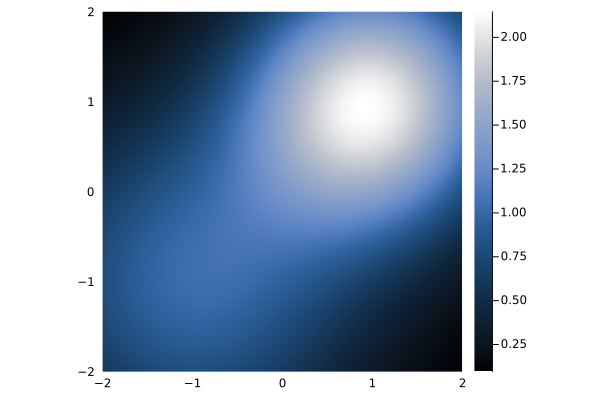

In [3]:
mu = [[-1,-1], [1,1]]
sigma2 = [2,1]
w = [1,2]

x1=(-2:.01:2)
x2=(-2:.01:2)

x=[[a,b] for b in x2, a in x1] ##el orden de b y a importa no entendí por qué.

z = rbf.(x, weights=w,centers=mu,sigma2=sigma2)

heatmap(x1,x2,z, aspect_ratio=:equal, c=:oslo, axis=:off, lims=(-2,2))

In [4]:
function sample_rbf(N,rbf_func,xlims,ylims,cota=1.0)
    
    v=Vector{Vector{Float64}}(undef,N)
    n=0
    
    while(n<N)
        
        u1 = rand(Uniform(xlims[1],xlims[2]))
        u2 = rand(Uniform(ylims[1],ylims[2]))

        u = rand(Uniform())
        
        val  = rbf_func([u1,u2])
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = [u1,u2]
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

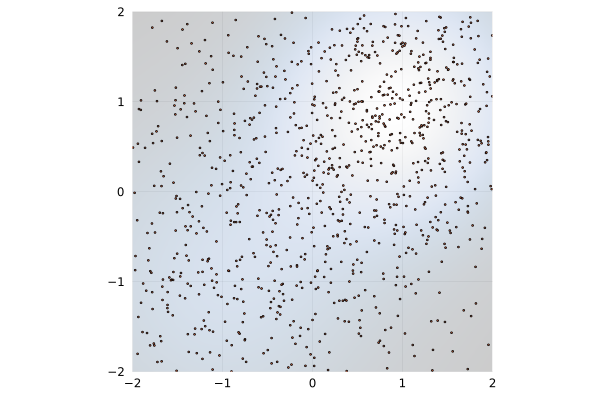

In [5]:
points = sample_rbf(1000, x->rbf(x;weights=w,centers=mu,sigma2=sigma2) ,(-2,2), (-2,2), 2.5)

heatmap(x1,x2,z, aspect_ratio=:equal, c=:oslo, axis=:off, lims=(-2,2),colorbar=:none, alpha=0.2)
scatter!([p[1] for p in points],[p[2] for p in points], aspect_ratio=:equal, axis=:off, lims=(-2,2), label=:none, ms=1)

In [6]:
function integrate2(h,grid,dx,dy)
    return sum(h.(grid)*dx*dy)
end

integrate2(x->rbf(x,weights=w,centers=mu,sigma2=sigma2),x,.01,.01)

15.85890199327471

In [7]:
function distance(x,y)
    sqrt(sum((x-y).^2))
end

distance (generic function with 1 method)

In [8]:
function average_over_voronoi(f::Function, u::Vector{Vector{Float64}}, y::Vector{Vector{Float64}})

    N=length(u)
    F = zeros(length(y))
    for k=1:N
        _,idx = findmin(distance.(y,Ref(u[k])))
        F[idx]+=f(u[k])
    end

    integrals = 1/N * F
    
end



average_over_voronoi (generic function with 1 method)

In [58]:
xlims=[-2.0,2.0]
ylims=[-2.0,2.0]
area = (xlims[2]-xlims[1])*(ylims[2]-ylims[1])

Nsites = 100
sites = [ [rand(Uniform(xlims[1],xlims[2])), rand(Uniform(ylims[1],ylims[2]))]   for i=1:Nsites]


N=10000

u1=rand(Uniform(xlims[1],xlims[2]),N)
u2=rand(Uniform(ylims[1],ylims[2]),N)

u = [[u1[i],u2[i]] for i=1:N]

y= average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;

In [59]:
function update_w(mu,sigma2,y,sites,u,area)

    Nsites = length(sites)
    A=zeros(Nsites,length(mu))

    for j=1:length(mu)
        A[:,j] = average_over_voronoi(x->rbf(x;weights=[1.0],centers=[mu[j]],sigma2=[sigma2[j]]), u, sites)*area
    end
    return A\y
end

update_w (generic function with 1 method)

In [111]:
function compute_gradient(w,mu,sigma2, y, sites, u, area)

    yact = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = yact - y

    dw1 = residuals'*average_over_voronoi(x->rbf(x,weights=1.0,centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dw2 = residuals'*average_over_voronoi(x->rbf(x,weights=1.0,centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;
    dmu11 = residuals'*average_over_voronoi(x->(x[1]-mu[1][1])/(sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dmu12 = residuals'*average_over_voronoi(x->(x[2]-mu[1][2])/(sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dmu21 = residuals'*average_over_voronoi(x->(x[1]-mu[2][1])/(sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;
    dmu22 = residuals'*average_over_voronoi(x->(x[2]-mu[2][2])/(sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[2]],sigma2=sigma2[2]), u, sites)*area;

    dsigma1 = residuals'*average_over_voronoi(x->sum((x-mu[1]).^2)/(2*sigma2[1]^2)*rbf(x,weights=w[1],centers=[mu[1]],sigma2=sigma2[1]), u, sites)*area;
    dsigma2 = residuals'*average_over_voronoi(x->sum((x-mu[2]).^2)/(2*sigma2[2]^2)*rbf(x,weights=w[2],centers=[mu[1]],sigma2=sigma2[2]), u, sites)*area;

    return [dw1,dw2,dmu11,dmu12,dmu21,dmu22,dsigma1,dsigma2]
end


compute_gradient (generic function with 1 method)

In [112]:
function compute_loss(w,mu,sigma2, y, sites, u, area)

    yact = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = yact - y
    return sum(residuals.^2)

end

compute_loss (generic function with 1 method)

In [130]:
mu0 = [[0.8,0.8],[-0.8,-0.8]]
sigma20 = [1.0,1.0]

w0=[1.0,1.0]
nu=0.05

west=w0
muest=mu0
sigma2est=sigma20

N=10000

niter=100
L=zeros(niter)

for iter=1:niter

    u1=rand(Uniform(xlims[1],xlims[2]),N)
    u2=rand(Uniform(ylims[1],ylims[2]),N)
        
    u = [[u1[i],u2[i]] for i=1:N]

    grad = compute_gradient(west,muest,sigma2est,y,sites,u,area)
    west = west - nu*grad[1:2]
    muest = [muest[1]-nu*grad[3:4],muest[2]-nu*grad[5:6]]
    sigma2est = sigma2est - nu*grad[7:8]
#    west = update_w(muest,sigma2est,y,sites,u,area)
    L[iter] = compute_loss(west,muest,sigma2est,y,sites,u,area)
end


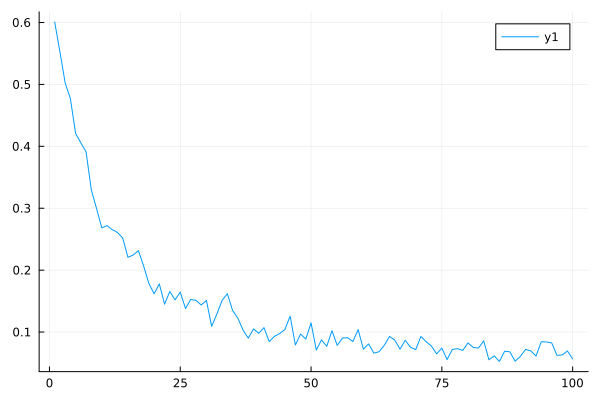

In [131]:
plot(L)

In [134]:
west

2-element Vector{Float64}:
 1.6620760073065972
 0.9782568051538693